# SED fitting of a data cube

In this tutorial we're going to go over the steps to fit each spectrum from a data cube that has already been voronoi binned (see `Voronoi_binning_of_SED_data.ipynb`). We are **NOT** going to assume that the BPASS-hoki templates for `ppxf` have been created so we will do that. 

Once we have been through all the steps in this jupyter notebook the actual fitting will be done in the python script `make_fits.py`. The reason we do this in a script and not in the notebook is because it is a time consuming process and jupyter adds overheads. If you're wondering why we create the templates outside of the `make_fits.py` script and not directly within it, that's because you might want to try to fit your galaxy with different ensembles of templates with more or fewer metallicities. For a discussion on how adding more metallicities to your group of templates can actually make your life worse and not better is the Supplementary Information in Stevance et al. 2023. 


In [21]:
import numpy as np
from ppxf import ppxf_util
from hoki.sedfitting import KVN, plot_voronoi
from hoki.constants import BPASS_METALLICITIES
c = 299792.458  # speed of light

## 1. Set-up: Making templates and normalising sample of spectra

In [2]:
# THIS WILL NEED UPDATING TO WORK ON YOUR MACHINE
BPASS_MODEL_PATH = '../../BPASS_hoki_dev/bpass_v2.2.1_imf135_300/' 

In [3]:
# To know how to extract vorbinned spectra and errs see relevant jupyter notebook
WL0=np.load('data/vorbinned_spectra.npy')[0]                                  # 1D np.array of obs. wl
spectra=np.load('data/vorbinned_spectra.npy')[1:]                             # 1D np.array of obs. flux
noise=np.load('data/vorbinned_specerr.npy')[1:]                               # 1D np.array of errs on flux

In [4]:
# BPASS metallicities to include in the templates 
met_list=['z010','z020', 'z030']

In [5]:
# list of BPASS metallicities in hoki.constants for reference
BPASS_METALLICITIES

['zem5',
 'zem4',
 'z001',
 'z002',
 'z003',
 'z004',
 'z006',
 'z008',
 'z010',
 'z014',
 'z020',
 'z030',
 'z040']

In [6]:
# for NGC4993 MUSE observations the delta_lambda of the spectrum is 1.25 Angstrom
fwhm_obs = 1.25   

In [7]:
outfile = 'data/kvn_010_020_030.pkl'  # save location of the templates 

In [8]:
################################
#  NORMALISING EACH SPECTRUM   #
################################
# Specifically we are dividing each spectrum by its median so they are all on roughly the same scale
norm_fluxes, norm_errs, median_flux_ls = [], [], []

for spec, err in zip(spectra, noise):
    med = np.nanmedian(spec)                                                  # median of ith spectrum in our sample
    median_flux_ls.append(med)                                                # storing the median for later use
    norm_fluxes.append((spec/med)[1:-1])                                      # normalising the flux
    norm_errs.append((err/med)[1:-1])                                       # same on the noise to conserve SNR

WL = WL0[1:-1]                                                                # making sure WL has same shape as flux
# NOTE: "Why [1:-1]?" Because when I was working on NGC4993 the data sometimes was messed up
# in the first or last (often last) bin of the spectra so I cropped them. This can be removed for your use.

norm_fluxes, norm_errs = np.array(norm_fluxes), np.array(norm_errs)       # lists to arrays to do maths

In [9]:
# A data class would be a good way to put this stuff together and will be coming in future 
# hoki updates. For now being explicit separating the components of the data so the code
# is easier to read. 
np.save('data/normalised_spectra_WL.npy', WL)
np.save('data/normalised_spectra.npy', norm_fluxes)
np.save('data/normalised_specerr.npy', norm_errs)
np.save('data/median_flux_list.npy', np.array(median_flux_ls))

In [10]:
norm_fluxes.shape

(1494, 3679)

In [9]:
###################################
# SET-UP STEPS TO MAKE PPXF HAPPY #
###################################

# Calculating the recessional velocity - that will be our "guess" for the LOSV
# LOSV = Line-of-sight velocity. This is what I often call the recessional velocity in tutorials and scripts

z = 0.009783                                                                  # z from Hjorth et al. 2017
recessional_vel = z*c                                                         # redshift * speed of light

start = [recessional_vel, 160]                                                # start guesses for [LOSV, dispersion]km/s


# Natural log rebinning using ppxf_util
flux, loglamgalaxy, velscale = ppxf_util.log_rebin([WL[0], WL[-1]],           # wavelength range of observations
                                                    norm_fluxes[200]          # one of the spectra (random)
                                                  )

In [12]:
##########################
# MAKING THE TEMPLATES   #
##########################

kvn = KVN()                                                                   # Instanciating new ppxf helper
kvn.make_templates(BPASS_MODEL_PATH,                                          # set by user at the top
                   fwhm_obs=fwhm_obs,
                   wl_obs=WL,
                   wl_range_obs=[WL[0], WL[-1]],
                   velscale_obs=velscale,                                     # calculated by ppxf_util.log_rebin
                   wl_range_padding=[-50,50],                                 # only change if needed
                   z_list=met_list,                                           # set by user at the top
                  )

kvn.save(outfile)

[---INFO---] TemplateMaker Starting
[--RUNNING-] Initial Checks
[--RUNNING-] Loading  model spectrum
[--RUNNING-] Calulating obs. velocity scale -- No dispersion
[--RUNNING-] Calculating template wavelength (log rebin) and velocity scale
[--RUNNING-] Calculating sigma
[--RUNNING-] Instanciating container arrays
[---INFO---] Using all ages from 6.0 to 10.2 (included) - log_age_cols now set
[--RUNNING-] Compiling your templates
Progress: |██████████████████████████████████████████████████| 100.00% Complete
[-COMPLETE-] Templates compiled successfully


## 2 - Running the fits for the whole data cube
Note I say "whole" data cube but the cube we are working with has been cropped down to contain NGC 4993 only and it would take significantly longer to do it for a full MUSE cube. 
Depending on how well or badly the fits go I average between 2 iterations (fits) per seconds and 3 seconds per fit. The better your SNR (generally) the lesser the struggle and different voronoi bins will take more or less time to fit. (note I have 12 CPUs working on this, it'll be faster if you are more of them or they have higher clock rates)

**It is a time consuming process** we are fitting nearly 1500 spectra - if you have more metallicities you try to fit over you'll also slow the process down. 

As a general rule of thumb I would recommend doing individual fits of some of the voronoi bins in key regions of the galaxy (e.g. center, arms, outskirts) where you can take a close look at what goes in and how it comes out and iterate. You can do fits like we did in the region around AT2017gfo but instead of doing the whole integrating flux in concentric annulii just pick a voronoi bin and fit that. 

For this tutorial, if you've gotten to that point you should be able to just run:
`
python make_fits.py
`

### 2.1 - Quality control 
Now at this point we have nearly 1500 SED fits, all with their star formation histories, kinematic information, etc stored away in an hdf5 file created by `make_fits.py`. The helper function `LordCommander` handled the fits and stored away the solutions that we would have in our individual `KVN` object. We don't want to have 1500 `KVN` objects, because that would be a tremendous duplication of information (e.g. all the templates). 

Let's make a few necessary imports and take a look at what `LordCommander` created for us. 

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import pickle 

from astropy.wcs import WCS
from hoki import load
from hoki.sedfitting.lordcommander import LordCommander

In [186]:
# to see the tables it created:
LordCommander?

Okay let's load our data! you don't need to open the hdf5 file directly because what we stored in there are pandas data frames (each a dataset within our group), which means you can just read those back into pandas with the `pd.read_hdf` function. 

Note that we didn't necessarily need to put that data in a group but if you'd wanted to try alternative settings for your fits and put them all in the same files you could have the results in different groups (e.g. if you want to include redenning).

**LOADING THE DATA**

In [137]:
FILE='data/ngc4993_010_020_030_clean.h5'                          # location of the .hdf5 file
FOLDER=f'kvn_010_020_030_cleanTrue'                               # group where the datasets are located

# see LordCommander documentation for the table names
bestfit=pd.read_hdf(FILE, key=f'{FOLDER}/BEST_FIT')
sfh=pd.read_hdf(FILE, key=f'{FOLDER}/SFH')
dyn=pd.read_hdf(FILE, key=f'{FOLDER}/DYNAMICS')
chi2=pd.read_hdf(FILE, key=f'{FOLDER}/CHI2')
scale_factors=pd.read_hdf(FILE, key=f'{FOLDER}/SCALE_FACTOR')
match_spectra=pd.read_hdf(FILE, key=f'{FOLDER}/MATCH_SPECTRA')
polynomials = pd.read_hdf(FILE, key=f'{FOLDER}/MATCH_APOLY')
flags=pd.read_hdf(FILE, key=f'{FOLDER}/FLAGS')

**Extra set-up to make pretty plots**

In [138]:
# this is just to get the WCS info for our plots below
with open('data/cropped_NGC4993.pkl', 'rb') as pickle_file:
    cube = pickle.load(pickle_file)
    
wcs = WCS(cube.get_wcs_header())
wcs = wcs.dropaxis(2)
del cube

# voronoi bin information required for the plots
voronoi_bins = pd.read_csv('data/voronoi_bins.txt')
x,y, sn, binNum = voronoi_bins.x.values, voronoi_bins.y.values, voronoi_bins.sn.values, voronoi_bins.binNum.values
binNum=binNum.astype('int')

**2.1.1 Quality control: CHI2 and SNR**

One of the first things to do is to look at the chi2. If it's high your fits likely don't have the right kinematics (although we can check on that a little down below). The chi2 will be somewhat dependent on the value of the SNR and that is why I like the plot both next to each other to see if there are any patterns in the chi2 that are not consisttent with the stuff we see in the SNR

Text(0.5, 1.0, 'SNR')

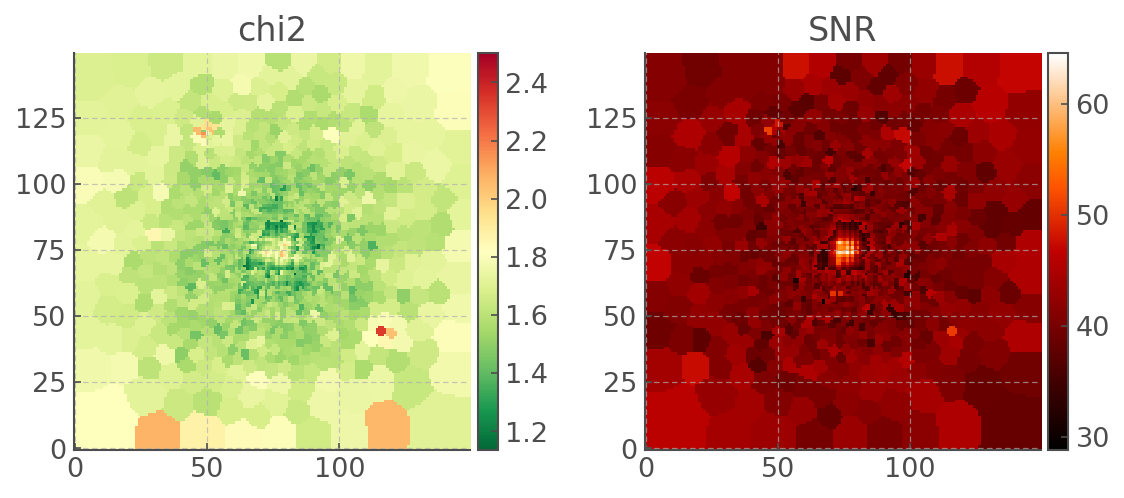

In [139]:
fig, ax = plt.subplots(1,2, figsize=(9,3.5))
chi2_cb = plot_voronoi(x, y, chi2.values.T[0][binNum], pixelsize=1, ax=ax[0], vmax=2.5,
                        cmap='RdYlGn_r')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
fig.colorbar(chi2_cb, cax=cax0, orientation='vertical')
ax[0].set_title("chi2")

#fig, ax = plt.subplots(1,1, figsize=(5,3.5))
sn_cb = plot_voronoi(x, y, sn, pixelsize=1, ax=ax[1], #vmax=2.5,
                        cmap='gist_heat')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sn_cb, cax=cax1, orientation='vertical')
ax[1].set_title("SNR")

Above you'll note a few regions of poorer chi2: 
* the location of AT 2017gfo -> because of the transient light we don't fit it well with just stars. Makes sense
* There is another point source (bottom right) which will naturally be poorly fit by the integrated spectrum of a stellar population and we can see it glow in the chi2. 
* Two big voronoi bins at the bottom: They are on the edge of the galaxy and massively binned becasue the data is not ideal. There just isn't much galaxy light in their to fit well
* The center of the galaxy..... Let's talk about this a bit more down below with another form of Quality Control


**2.1.2 - FLAGS**

One of the tables we got from our hdf5 file is called FLAGS. In the class that drives the multiple ppxf fits I set up some FLAGS relating to the chi2, LOSV and the dispersion, to track the bins that deviate from the average and by how much: 2 sigma, 3 sigma, 5 sigma. 

Below is a copy-paste of the documentation:

```
Contains the flags. During the fitting procedure, flags are created when the chi2 value or
dynamical parameters are higher than the median for the whole galaxy.
=> There are flags for deviations by 2, 3 and 5 standard deviations.
The value of the flag is:
    - 2,3,5 for the Chi2
    - 20,30,50 for the LOSV
    - 200,300,500 for the dispersion.

So a TOTAL flag with value 553 has a 3 sigma deviation in the Chi2, a 5 sigma diviation in the LOSV
and a 5 sigma deviation in the dispersion.
```

Now let's look at the table:

In [140]:
flags[flags.TOTAL!=0] # the mask crops all the bins that show no flags

CHI2  LOS  DISP  TOTAL
bin_id                        
0          2    0     0      2
15         2    0     0      2
44         3    0     0      3
101        3    0     0      3
157        2    0     0      2
438        2    0     0      2
447        2    0     0      2
469        3    0     0      3
499        2    0     0      2
527        5   50   500    555
531        2    0     0      2
556        3    0     0      3
558        2    0     0      2
562        2    0     0      2
585        2    0     0      2
587        2    0     0      2
637        3   50   500    553
657        2    0     0      2
659        2    0     0      2
661        3    0     0      3
684        2    0     0      2
1332       2    0     0      2
1397       0   50   500    550
1400       0   30   500    530
1403       0    0   200    200
1405       3   50   500    553
1409       3   50   500    553
1410       0    0   300    300
1413       2   20   500    522
1416       3   50   500    553
1417       2   50   500    552
1420       3    0     0      3
1425       0    0   500    500
1427       3   30   500    533
1428       3   30   500    533
1432       2    0   500    502
1434       2   30   500    532

that's neat but not very human readable or at least not easy to interpret for a human brain - we need pictures!
Let's plot all of the regions that have at least some issue with their chi2:
* Those with a very bad chi2 (more than 5 sigma deivation from average) and or kinematic fit issues (v. problematic, because you can get the kinematics right usually even if the SFH is poor so those bad kinematics are a bad sign). 
* Those with chi2 deviation of 3 sigma but not more. Those are bad fits, but not awful. 

Text(0.5, 1.0, 'Flags==3 over chi2 map')

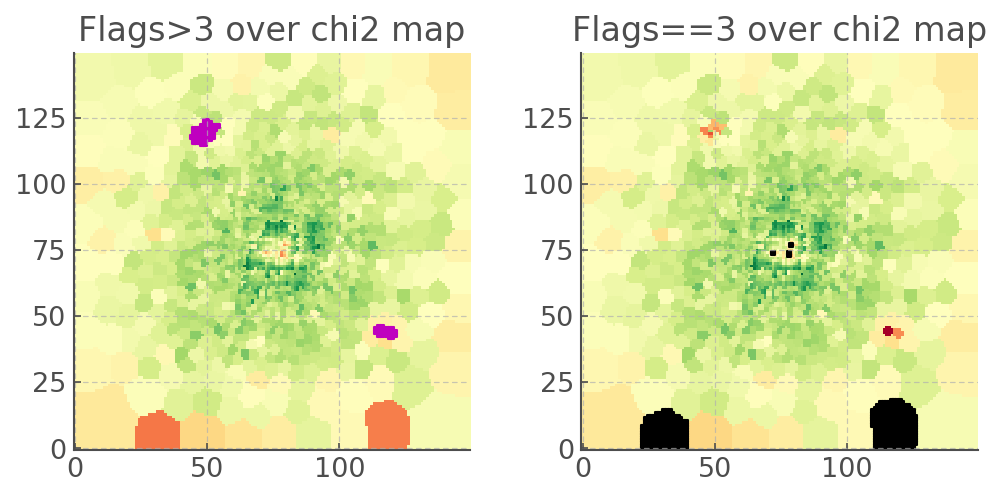

In [141]:
mask = np.isin(binNum, flags[flags.TOTAL>3].index.values)
mask2 = np.isin(binNum, flags[flags.TOTAL>2].index.values)

fig, ax = plt.subplots(1,2, figsize=(8,3.5))
chi2_cb = plot_voronoi(x, y, chi2.values.T[0][binNum], pixelsize=1, ax=ax[0], 
                        cmap='RdYlGn_r')
chi2_cb = plot_voronoi(x, y, chi2.values.T[0][binNum], pixelsize=1, ax=ax[1], 
                        cmap='RdYlGn_r')


ax[0].scatter(x[mask], y[mask], color='m', marker='s', s=5)
ax[0].set_title("Flags>3 over chi2 map")
ax[1].scatter(x[mask2 & ~mask], y[mask2 & ~mask], color='k', marker='s', s=5)
ax[1].set_title("Flags==3 over chi2 map")

As we can see things go very wrong where our point sources are - which makes sense! there is no reason our SEDs should fit those well. We could use the FLAGS as a way to filter potential point sources in the way (if you are dealing with a v. crowded field) but that's not what they were meant for so use caution. 

Now the FLAGS==3 is interesting: Here again we have the voronoi bins at the bottom (which have terrible spectra) and some bins in the middle of the galaxy. Spoiler alert, there is a LIER region in the middle (and other bits of the galaxy) so it could be that... or it could be that the SNR is super high there and so thi chi2 very poor because it's fitting data with smaller uncertainties. 

Best way to check is to plot all that! 


#### 2.1.3 - Plotting spectra from individual vorbins

There is a little bit of faffing around with indicies to plot spectra from specific bins you identify in your plot as needing an extra look. It's not particularly complex, just have to know where to look and where pas me decided things should be located, so let me show you:

**Let's plot all the spectra from the FLAGS==3 voronoi bins**

First we have our bin ID in the flags table so that's handy

In [142]:
flags[flags.TOTAL==3]

CHI2  LOS  DISP  TOTAL
bin_id                        
44         3    0     0      3
101        3    0     0      3
469        3    0     0      3
556        3    0     0      3
661        3    0     0      3
1420       3    0     0      3

In [143]:
binID_flag3 = flags[flags.TOTAL==3].index.values
binID_flag3

array([  44,  101,  469,  556,  661, 1420])

These bin_id numbers are directly related to the first dimension of our `spectra` and `norm_fluxes` numpy arrays (which are 2D arrays with shape [number voronoi bins, number of wavelength bins].

In [144]:
spectra.shape

(1494, 3681)

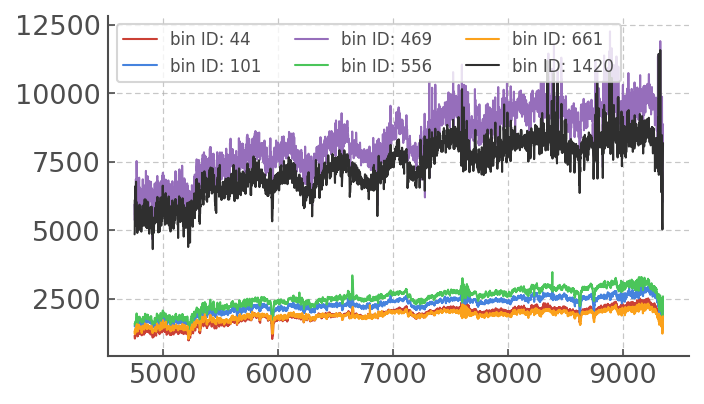

In [145]:
for i in binID_flag3:
    plt.plot(WL0[1:-1],# first and last bin sometimes ugly so i crop it for the plot
             spectra[i,:][1:-1], # fluxes pre normalisation so they're not fully on top of each other
             label=f'bin ID: {i}',
             lw=1,
            ) 
    
plt.legend(ncol=3, fontsize=8)

That's nice but there are 6 binsa nd 6 spectra, which belongs to where? You can sort of figure it out from the bin number but it's a weird tranformation of a 2D grid into a 1D grid in your head not really remembering where voronoi bin 0 is (top? bottom? righ? left?)

Instead let's mark them on our maps!

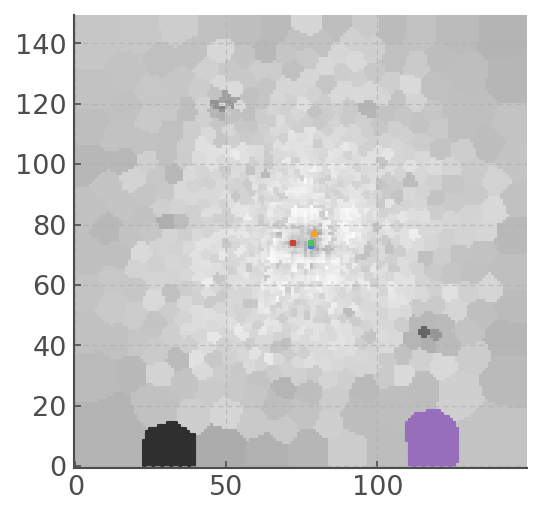

In [146]:
fig, ax = plt.subplots(1, figsize=(4,4))
chi2_cb = plot_voronoi(x, y, chi2.values.T[0][binNum], pixelsize=1, ax=ax, 
                        cmap='Greys', alpha=0.6)

for i in binID_flag3:
    _mask_i = np.isin(binNum, i)
    ax.scatter(x[_mask_i], y[_mask_i],  marker='s', s=5)

It is no surprise that the super noise spectra belong to the voronoi bins on the edger of the image. The other 4 in the galactic center need zooming in:

(5000.0, 9300.0)

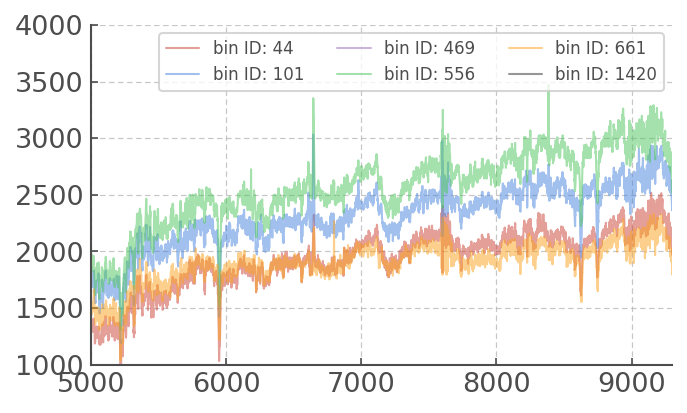

In [147]:
for i in binID_flag3:
    plt.plot(WL0[1:-1],# first and last bin sometimes ugly so i crop it for the plot
             spectra[i,:][1:-1], # fluxes pre normalisation so they're not fully on top of each other
             label=f'bin ID: {i}',
             lw=1, alpha=0.5,
            ) 
    
plt.legend(ncol=3, fontsize=8)
plt.ylim(1000,4000)
plt.xlim(5000,9300)

There seems to be som emission lines that will affect the chi2 and also the spectra are a lot less noisy indeed. One final point we won't talk about too much here (but you can check the Supplementary information of Stevance et al. 2023 for a discussion) is that these spectra are clearly reddenned and it's possible our approach of ignoring reddening and hoping the 2nd order polynomial will do the job may have hit its limits. 

With SED fitting there are plenty of little thigns like that you can iterate on to get the best it and in truth you could spend a whole PhD or postdoc refining things. But at the end of the day *the* solution for our star formation history is impossible to find, we can only hope to get estimates. So as you iterate and do further test consistently check in and ask yourself: is this going to improve my understanding of this galaxy? Is this going to help answer my science question? 

Okay let's get back to more practical matters...

### 2.2 - Kinematics
The main thing that `ppxf` was designed for originally was extracting the kinematic behaviour of our spatially resolved galaxies. Here is a quick way to plot the dynamical information that is stored in our `DYNAMICS` table (which we called `dyn` earlier). **NOTE:** we are handling the "bad" data in a quick and dirty way below by inputing it with the mean of the LOSV and dispersion velocity (if the values in a given bin are stupid high or stupid low and ruin our colour bar). You can do a more thorough job by refitting those bins or jsut flagging them as discrepant (like we had with our flags earlier). 

In [148]:
def quick_plot_dynamics(los_vel,     # line of sight velocity
                        disp_vel,    # dispersion velocity
                        yeet=None    # the bins to ignore (e.g. if you want to not plot the point sources)
                       ): 
    
    disp_vel=np.concatenate([disp_vel, np.array([disp_vel.mean()])])
    los_vel=np.concatenate([los_vel, np.array([np.nanmean(los_vel)])])

    

    # "fixing" the LOSV that are too low or high so the colorbar range isn't ruined
    
    # if LOSV <2700 km/s in that bin, use the recessional_vel value, otherwise keep it as is in the array
    los_vel_fix = np.where(los_vel<2700, recessional_vel, los_vel)
    # if LOSV >3000 km/s in that bin, use the recessional_vel value, otherwise keep it as is 
    # (in our new fixed array that has had its lwo values laready "fixed")
    los_vel_fix = np.where(los_vel_fix>3000, recessional_vel, los_vel_fix)
    
    # same idea for the dispersion - we inpute with the median deispersion of the whole sample
    disp_vel_fix = np.where(disp_vel>210,  np.median(disp_vel), disp_vel,)
    disp_vel_fix = np.where(disp_vel_fix<120, np.median(disp_vel_fix),  disp_vel_fix)
    
    try:
        for i in yeet: # if we want to ignore (i.e yeet) bins from our plotting 
            los_vel_fix[i]=np.nan
            disp_vel_fix[i]=np.nan
    except TypeError: # catches instance when yeet not given - wow that was a lazy way to do it
        pass

    
    fig, ax = plt.subplots(1,2, figsize=(15,7))
    
    ## PLOT LOSVD
    sn_color0 = plot_voronoi(x, y, # pixel coordinates we extracted from our voronoi_bin table earlier
                             los_vel_fix[binNum]-np.nanmedian(los_vel_fix), # center on zero using the median
                             pixelsize=1, 
                             ax=ax[0], 
                             cmap='coolwarm' # towards us is red, away from us is blue - DOPPLER!
                            )

    # all this to play with the location of the color bar
    divider0 = make_axes_locatable(ax[0]) 
    cax0 = divider0.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(sn_color0,cax=cax0, orientation='vertical')
    ax[0].set_title('LOSVD')

    ## PLOT DISPERSION
    sn_color1 = plot_voronoi(x, y, 
                             disp_vel_fix[binNum], 
                             pixelsize=1, 
                             ax=ax[1], 
                             cmap='viridis')
    
    divider1 = make_axes_locatable(ax[1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(sn_color1,cax=cax1, orientation='vertical')
    ax[1].set_title('dispersion')


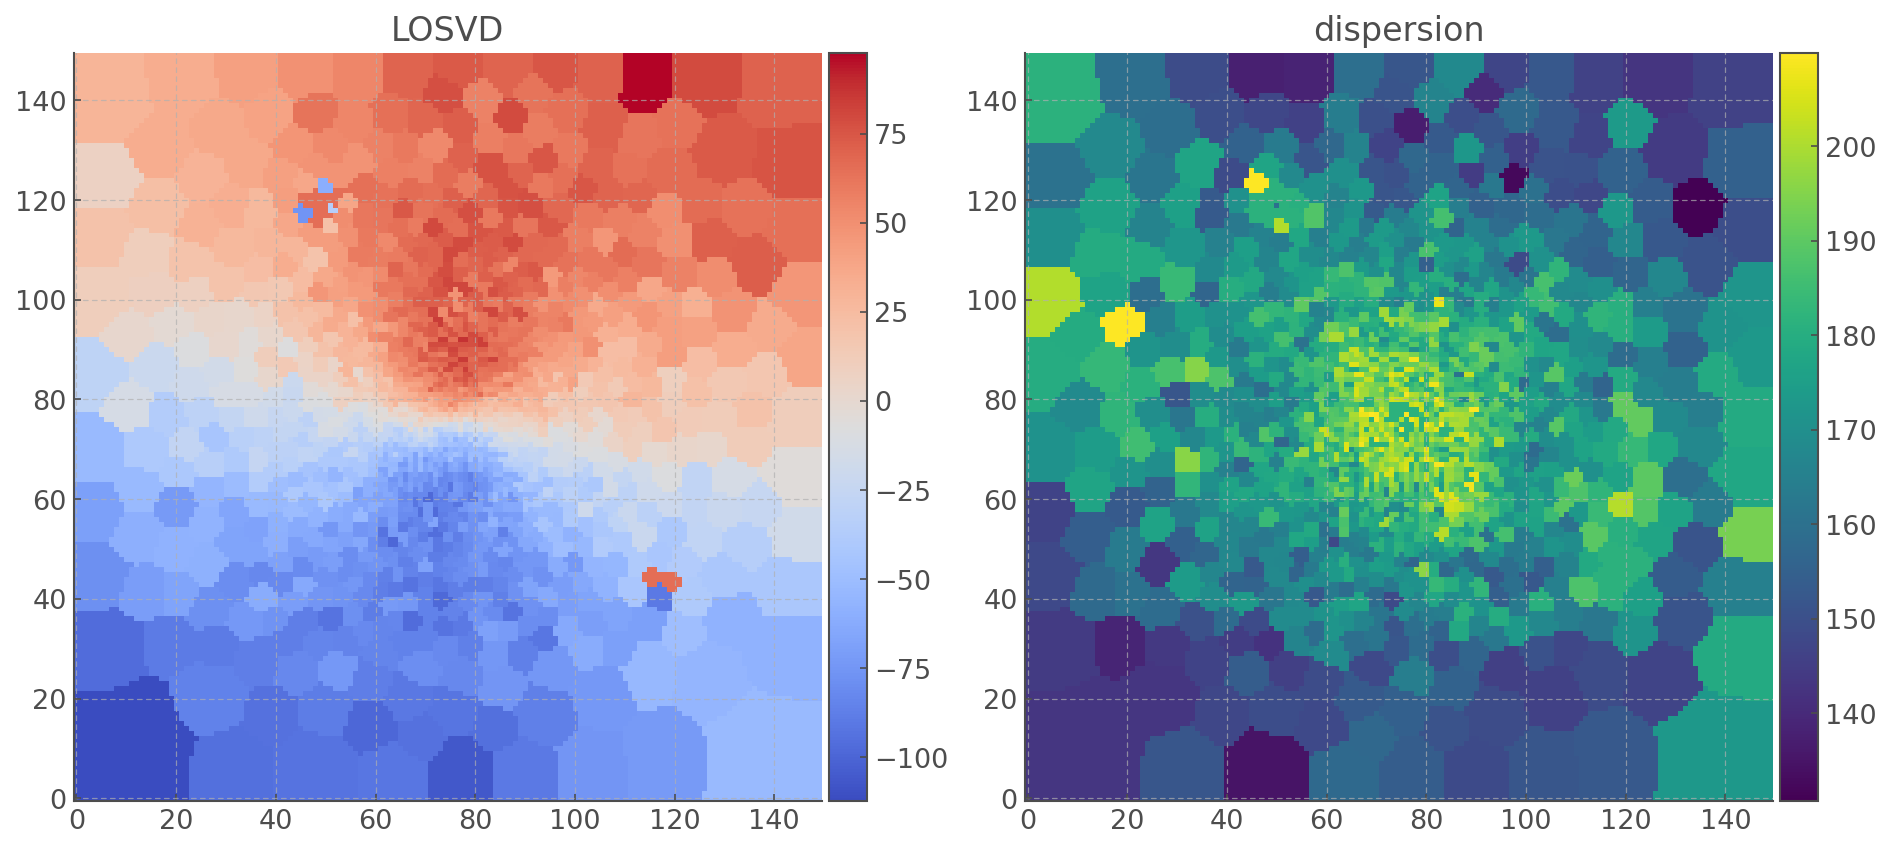

In [149]:
los_vel, disp_vel = dyn.los.values, dyn.disp.values
quick_plot_dynamics(los_vel, disp_vel)

### 2.3 - Star Formation History

Finally, the reason we've done all this in the first place: the Star Formation History. 
There are two main ways to plot this: first of all the light fraction, which we get directly from the SED fitting and `ppxf`. The other way is the mass fraction, which is a more useful physical quantity the majority of the time. With the BPASS models and our hoki utilities it'll be easy to derive the mass fraction SFH once we've organised our light fraction SFH. 

#### 2.3.1 Light Fraction

The first thing to do is to calculate the light fraction for each component in each of our voronoi bins. **The light fraction in each voronoi bin should sum to 1.0**.

In [150]:
## first we group by bin ID to calculate the sum of the weights
## remember form an earlier tuto, the ppxf weights don't always sum to 1.
total_light = sfh.groupby('bin_id').sum().weights

# this will make our life easier (see below)
sfh = sfh.set_index('bin_id') 

# then we calculate the light fraction
light_fraction = sfh.weights.divide(total_light)
sfh['light_fraction']=light_fraction

In [151]:
sfh.head()

met   age   weights  light_fraction
bin_id                                      
0       0.02   8.9  0.092715        0.134078
0       0.03   9.0  0.028412        0.041088
0       0.01   9.7  0.138911        0.200882
0       0.02  10.1  0.044917        0.064955
0       0.03  10.1  0.386549        0.558997

say we want to know the star formation history of bin 200, we can use `.loc` because we set the index to be `bin_id`. 

In [152]:
sfh.loc[200]

met   age   weights  light_fraction
bin_id                                      
200     0.02   8.9  0.064498        0.082065
200     0.03   9.0  0.097817        0.124459
200     0.01  10.0  0.623623        0.793476

Okay now we are going to separate out the components from different metallicities, because at the end of the day we'd like to plot those individually. You could create your own functions or a data class to handle the stuff below if it gets too repetitive with added metallicities

In [153]:
# New SFH data frames that only contain one metallicity
sfh010=sfh[sfh.met==0.010]
sfh020=sfh[sfh.met==0.020]
sfh030=sfh[sfh.met==0.030]

In [154]:
# Creating pandas Series grouping the light fraction by log age bin
lf_z010=sfh010.groupby('age').sum()['light_fraction']
lf_z020=sfh020.groupby('age').sum()['light_fraction']
lf_z030=sfh030.groupby('age').sum()['light_fraction']

In [156]:
lf_z010

age
6.6       0.005236
6.9       0.093890
8.6       1.458261
8.9      12.964961
9.0       1.123147
9.1      12.245958
9.2       0.287909
9.3       2.236460
9.4       4.510080
9.5      13.695983
9.6       0.011081
9.7     309.547829
9.8       5.104481
9.9     461.526415
10.0    288.287897
10.1     56.685633
Name: light_fraction, dtype: float64

In [157]:
# summing those light fractions so that we can...
total_lf = sum(lf_z010)+sum(lf_z020)+sum(lf_z030)

# ... normalise our Series
lf_z010/=total_lf
lf_z020/=total_lf
lf_z030/=total_lf

In [158]:
lf_z010

age
6.6     0.000004
6.9     0.000063
8.6     0.000976
8.9     0.008678
9.0     0.000752
9.1     0.008197
9.2     0.000193
9.3     0.001497
9.4     0.003019
9.5     0.009167
9.6     0.000007
9.7     0.207194
9.8     0.003417
9.9     0.308920
10.0    0.192964
10.1    0.037942
Name: light_fraction, dtype: float64

In [169]:
# Creating a new data frame to store the SFH we want to plot
# it groups the results by metallicity and age 
df_sfh= pd.DataFrame(np.zeros((3,38)), 
                     columns = ['met']+list(np.round(np.arange(6.5, 10.2, 0.1),2).astype(str))
                    )
df_sfh['met']=[0.010, 0.02, 0.03]

In [170]:
df_sfh.head() # currently filled with 0

met  6.5  6.6  6.7  6.8  6.9  7.0  7.1  7.2  7.3  ...  9.2  9.3  9.4  9.5  \
0  0.01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   9.6  9.7  9.8  9.9  10.0  10.1  
0  0.0  0.0  0.0  0.0   0.0   0.0  
1  0.0  0.0  0.0  0.0   0.0   0.0  
2  0.0  0.0  0.0  0.0   0.0   0.0  

[3 rows x 38 columns]

In [171]:
# now for each light fraction value in our SFH data frames split by metallicity
# we add that light fraction to the corresponding age and metallicity cell 
# in the df_sfh dataframe which summarises the results

for lf, age in zip(sfh010.light_fraction.values, sfh010.age.values):
    # the rounding of the age is important below because otherwise 
    # your string can be 6.9999999999999999 instead of 7.0
    df_sfh.loc[:,str(np.round(age,2))][(df_sfh.met == 0.010)] += lf
    
for lf, age in zip(sfh020.light_fraction.values, sfh020.age.values):
    df_sfh.loc[:,str(np.round(age,2))][(df_sfh.met == 0.020)] += lf  
    
for lf, age in zip(sfh030.light_fraction.values, sfh030.age.values):
    df_sfh.loc[:,str(np.round(age,2))][(df_sfh.met == 0.030)] += lf

In [172]:
df_sfh

met  6.5       6.6  6.7  6.8       6.9  7.0  7.1  7.2  7.3  ...       9.2  \
0  0.01  0.0  0.005236  0.0  0.0  0.093890  0.0  0.0  0.0  0.0  ...  0.287909   
1  0.02  0.0  0.000000  0.0  0.0  1.156487  0.0  0.0  0.0  0.0  ...  0.000000   
2  0.03  0.0  0.000000  0.0  0.0  0.159848  0.0  0.0  0.0  0.0  ...  2.138571   

       9.3       9.4        9.5       9.6         9.7       9.8         9.9  \
0  2.23646  4.510080  13.695983  0.011081  309.547829  5.104481  461.526415   
1  0.00000  0.000000   0.000000  0.000000   31.516823  0.000000    0.000000   
2  0.10079  0.063345   0.000000  0.000000    0.000000  0.340492    0.000000   

         10.0       10.1  
0  288.287897  56.685633  
1    0.000000  77.343859  
2    0.282719  18.450697  

[3 rows x 38 columns]

Now to make plotting easier we can do some pandas *magic*...

In [173]:
# we set the index to the met column and then transpose
df_sfh=df_sfh.set_index('met').T
df_sfh.head()

met      0.01      0.02      0.03
6.5  0.000000  0.000000  0.000000
6.6  0.005236  0.000000  0.000000
6.7  0.000000  0.000000  0.000000
6.8  0.000000  0.000000  0.000000
6.9  0.093890  1.156487  0.159848

In [174]:
# we also normalise the results
df_sfh /= df_sfh.sum().sum()

In [176]:
df_sfh.tail()

met       0.01      0.02      0.03
9.7   0.207194  0.021096  0.000000
9.8   0.003417  0.000000  0.000228
9.9   0.308920  0.000000  0.000000
10.0  0.192964  0.000000  0.000189
10.1  0.037942  0.051770  0.012350

(16.0, 37.0)

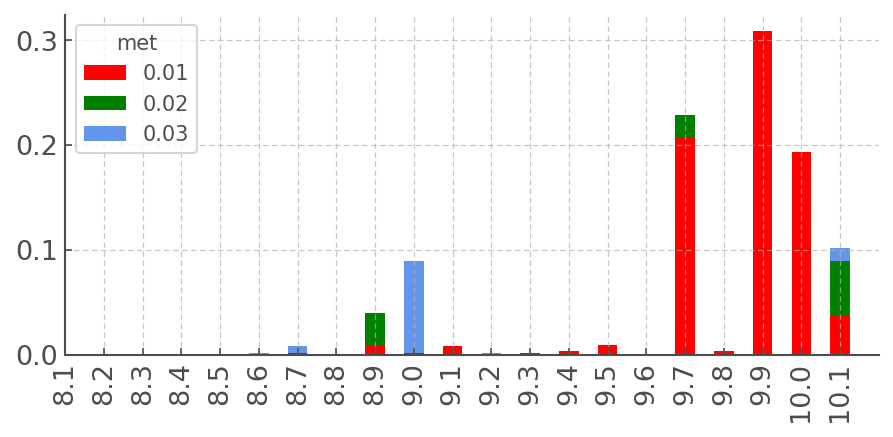

In [177]:
# then we can directly plot the stacked bar plot from pandas!
# so much easier than creating it from scratch in matplotlib!
f, ax = plt.subplots(nrows=1, figsize=(7,3))
df_sfh.plot.bar(stacked=True, ax=ax, color={0.01: "red",
                                            0.02: "green",
                                            0.03: "cornflowerblue",
                                             })
ax.set_xlim([16,37])

#### 2.3.2 Mass fraction

Okay so the final step is to turn this light fraction plot into a mass fraction one:
1) We need to turn the light fraction into a *current* mass fraction by comparing their absolute amplitude to our template SEDs absolute amplitude (and we know they are for 10^6 solar masses *at birth*
2) The discrepancy between the *current* mass fraction and the BPASS 10^6 solar masses *at birth* can be dealt with because we have in the BPASS outputs a table that tells us how much mass stellar mass remains at any given age bin. 

Let's do this step by step

In [41]:
# a) we load the BPASS SEDs (not the templates made with hoki) from the model outputs

spectra_010=load.model_output(BPASS_MODEL_PATH+'spectra-bin-imf135_300.z010.dat')
spectra_020=load.model_output(BPASS_MODEL_PATH+'spectra-bin-imf135_300.z020.dat')
spectra_030=load.model_output(BPASS_MODEL_PATH+'spectra-bin-imf135_300.z030.dat')

In [178]:
spectra_010.head()

WL           6.0           6.1           6.2           6.3           6.4  \
0  1.0  3.967282e-40  4.218233e-40  4.603921e-40  6.073403e-40  1.315608e-39   
1  2.0  3.967282e-40  4.218233e-40  4.603921e-40  6.073403e-40  1.315608e-39   
2  3.0  3.967282e-40  4.218233e-40  4.603921e-40  6.073403e-40  1.315608e-39   
3  4.0  3.967282e-40  4.218233e-40  4.603921e-40  6.073403e-40  1.315608e-39   
4  5.0  3.967282e-40  4.218233e-40  4.603921e-40  6.073403e-40  1.315608e-39   

            6.5           6.6           6.7           6.8  ...          10.1  \
0  3.371735e-39  7.411536e-39  3.407992e-38  5.704377e-38  ...  3.527645e-40   
1  3.371735e-39  7.411536e-39  3.407992e-38  5.704377e-38  ...  3.527645e-40   
2  3.371735e-39  7.411536e-39  3.407992e-38  5.704377e-38  ...  3.527645e-40   
3  3.371735e-39  7.411536e-39  3.407992e-38  5.704377e-38  ...  3.527645e-40   
4  3.371735e-39  7.411536e-39  3.407992e-38  5.704377e-38  ...  3.527645e-40   

           10.2          10.3          10.4          10.5          10.6  \
0  4.776701e-40  5.914132e-40  2.209390e-40  1.870472e-40  1.753484e-40   
1  4.776701e-40  5.914132e-40  2.209390e-40  1.870472e-40  1.753484e-40   
2  4.776701e-40  5.914132e-40  2.209390e-40  1.870472e-40  1.753484e-40   
3  4.776701e-40  5.914132e-40  2.209390e-40  1.870472e-40  1.753484e-40   
4  4.776701e-40  5.914132e-40  2.209390e-40  1.870472e-40  1.753484e-40   

           10.7          10.8          10.9          11.0  
0  1.592896e-40  3.193369e-40  1.166236e-40  4.273201e-41  
1  1.592896e-40  3.193369e-40  1.166236e-40  4.273201e-41  
2  1.592896e-40  3.193369e-40  1.166236e-40  4.273201e-41  
3  1.592896e-40  3.193369e-40  1.166236e-40  4.273201e-41  
4  1.592896e-40  3.193369e-40  1.166236e-40  4.273201e-41  

[5 rows x 52 columns]

In [179]:
# b) we load in the starmass table as well
starmass_bin_010=load.model_output(BPASS_MODEL_PATH+"starmass-bin-imf135_300.z010.dat")
starmass_bin_020=load.model_output(BPASS_MODEL_PATH+"starmass-bin-imf135_300.z020.dat")
starmass_bin_030=load.model_output(BPASS_MODEL_PATH+"starmass-bin-imf135_300.z030.dat")

In [180]:
starmass_bin_010.head()

log_age  stellar_mass  remnant_mass
0      6.0    1000000.00      0.000000
1      6.1    1000000.00      0.000000
2      6.2    1000000.00      0.000000
3      6.3     997982.20      0.002659
4      6.4     988740.77    840.775590

In [181]:
# c) we set a few useful variables 
wl_fits=bestfit.columns.values
wl_min, wl_max = wl_fits[0], wl_fits[-1]
L_sol = 3.846e33 # luminosity of the sun in cgs
d = 1.23e26 # distance to NGC4993 in cm
scale_to_observer_units = L_sol / (4*np.pi*d**2) # inverse square law!

In [182]:
# d) add some colums to our sfh table so we can store our results 
#    for the current mass and the ZAMS mass
sfh['Mzams'] = np.zeros(sfh.shape[0])
sfh['Mnow'] = np.zeros(sfh.shape[0])

In [183]:
sfh

met   age   weights  light_fraction  Mzams  Mnow
bin_id                                                   
0       0.02   8.9  0.092715        0.134078    0.0   0.0
0       0.03   9.0  0.028412        0.041088    0.0   0.0
0       0.01   9.7  0.138911        0.200882    0.0   0.0
0       0.02  10.1  0.044917        0.064955    0.0   0.0
0       0.03  10.1  0.386549        0.558997    0.0   0.0
...      ...   ...       ...             ...    ...   ...
1492    0.01   9.9  0.283420        0.345728    0.0   0.0
1493    0.03   9.0  0.102584        0.113960    0.0   0.0
1493    0.01   9.7  0.311537        0.346084    0.0   0.0
1493    0.01   9.9  0.473166        0.525637    0.0   0.0
1493    0.01  10.0  0.012889        0.014318    0.0   0.0

[6047 rows x 6 columns]

In [185]:
# another table we haven't talked about yet is going to come in handy
# the scale_factors: it allows use to transform our fit and template spectra from 
# normalised no-units spectra to real things with real units. 
scale_factors

median       to_ergs
bin_id                           
0       3199.449463  3.199449e-17
1       2818.566162  2.818566e-17
2       2808.959717  2.808960e-17
3       3148.326416  3.148326e-17
4       2370.432861  2.370433e-17
...             ...           ...
1489    2894.474315  2.894474e-17
1490    4660.632334  4.660632e-17
1491    3839.647448  3.839647e-17
1492    3379.250118  3.379250e-17
1493    4145.672011  4.145672e-17

[1494 rows x 2 columns]

In [187]:
####### CALCULATE M ZAMS ############

# for each row in sfh
for i in range(sfh.shape[0]):
    # we load the matching template (it contains the kinematics, that's okay), the light fraction
    # the age and the metallicity, and we keep track of which bin_id we're looking at
    spec, w, a, z = match_spectra.iloc[i,:], sfh.light_fraction.iloc[i], sfh.age.iloc[i], sfh.met.iloc[i]
    bin_id = sfh.index.values[i]

    # our template spectrum is converted to ergs and we multipled by its sfh light fraction weight w
    template_i = spec*scale_factors.to_ergs.iloc[bin_id]*w
    
    # bpass_i is the BPASS SED scaled to observer units, cropped to the right wavelengtth and 
    # at the right age and metallicity (this could be streamlined)
    if z == 0.01:
        # could do the iloc crop outside the loop...
        bpass_i = spectra_010.iloc[int(wl_min):int(wl_max)+1, :][str(np.round(a,2))]*scale_to_observer_units
        
    elif z == 0.02:
        bpass_i = spectra_020.iloc[int(wl_min):int(wl_max)+1, :][str(np.round(a,2))]*scale_to_observer_units
    
    elif z == 0.030:
        bpass_i = spectra_030.iloc[int(wl_min):int(wl_max)+1, :][str(np.round(a,2))]*scale_to_observer_units
        
    # Now to get the ZAMS mass we basically compare the mean flux of the template SED
    # that corresponds to a given SFH component (e.g. log age=8.0, Z=0.020) to the raw BPASS SED
    # converted to observer units 
    sfh['Mzams'].iloc[i]=np.mean(template_i)/np.mean(bpass_i)

In [189]:
###### CALCULATE MASS 'NOW' (AT GIVEN LOG AGE) ####

for i in range(sfh.shape[0]):
    # store the age, met and mass at zams for this particular row of the sfh 
    a,z,zams = sfh.age.iloc[i], sfh.met.iloc[i], sfh.Mzams.iloc[i]
    
    # then calculate the current mass by scaling by the corresponding row
    # in the starmass table from the bpass models. 
    # also dividing by 1e6 so that it's in PER 1 MILLION Msol like the Mzams is
    if z == 0.01:
        current_mass_i = zams*starmass_bin_010[starmass_bin_010.log_age==a].stellar_mass.values[0]/1e6
    elif z == 0.02:
        current_mass_i = zams*starmass_bin_020[starmass_bin_020.log_age==a].stellar_mass.values[0]/1e6
    elif z == 0.030:
        current_mass_i = zams*starmass_bin_030[starmass_bin_030.log_age==a].stellar_mass.values[0]/1e6 
    sfh['Mnow'].iloc[i] = current_mass_i 

In [190]:
sfh

met   age   weights  light_fraction      Mzams       Mnow
bin_id                                                            
0       0.02   8.9  0.092715        0.134078   0.898908   0.600884
0       0.03   9.0  0.028412        0.041088   0.422087   0.275592
0       0.01   9.7  0.138911        0.200882   7.425133   3.949804
0       0.02  10.1  0.044917        0.064955   6.836699   3.445810
0       0.03  10.1  0.386549        0.558997  60.280893  30.022886
...      ...   ...       ...             ...        ...        ...
1492    0.01   9.9  0.283420        0.345728  39.295878  19.853163
1493    0.03   9.0  0.102584        0.113960   2.056300   1.342613
1493    0.01   9.7  0.311537        0.346084  22.545483  11.993084
1493    0.01   9.9  0.473166        0.525637  70.939023  35.839992
1493    0.01  10.0  0.012889        0.014318   1.819800   0.911607

[6047 rows x 6 columns]

**NOTE: Mzams and Mnow are in PER 1 MILLION Msol**

In [195]:
# now we create our summary sfh dataframe just like we did for the light fraction!
df_sfh_mass = pd.DataFrame(np.zeros((3,38)), 
                           columns = ['met']+list(np.round(np.arange(6.5, 10.2, 0.1),2).astype(str))
                          )

df_sfh_mass['met']=[0.010, 0.02, 0.03]

In [196]:
# do this again to update the sfh010 020 030 tables to contain the mass information
sfh010=sfh[sfh.met==0.010]
sfh020=sfh[sfh.met==0.020]
sfh030=sfh[sfh.met==0.030]


In [197]:
for mass, age in zip(sfh010.Mnow.values, sfh010.age.values):
    df_sfh_mass.loc[:,str(np.round(age,2))][(df_sfh_mass.met == 0.010)] += mass
    
for mass, age in zip(sfh020.Mnow.values, sfh020.age.values):
    df_sfh_mass.loc[:,str(np.round(age,2))][(df_sfh_mass.met == 0.020)] += mass 
    
for mass, age in zip(sfh030.Mnow.values, sfh030.age.values):
    df_sfh_mass.loc[:,str(np.round(age,2))][(df_sfh_mass.met == 0.030)] += mass

In [198]:
# *magic* (see above when did it for df_shf)
df_sfh_mass=df_sfh_mass.set_index('met').T
# normalise
df_sfh_mass /= df_sfh_mass.sum().sum()

(16.0, 37.0)

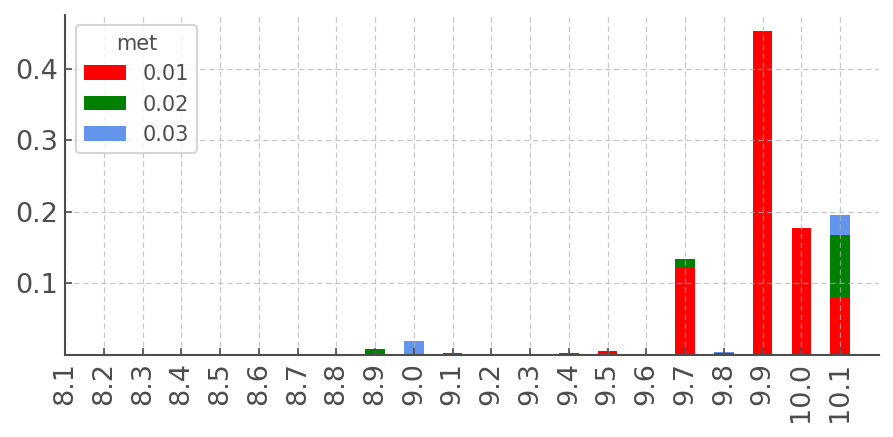

In [199]:
# plot!
f, ax = plt.subplots(nrows=1, figsize=(7,3))
df_sfh_mass.plot.bar(stacked=True, ax=ax, color={0.01: "red",
                                                0.02: "green",
                                                0.03: "cornflowerblue",
                                             })
ax.set_xlim([16,37])

# Final Plot!

Now we can plot our SFH in terms of light fraction and mass fraction altogether to put in our paper! woop woop!

Text(19, 0.38, 'Metallicity (Z)')

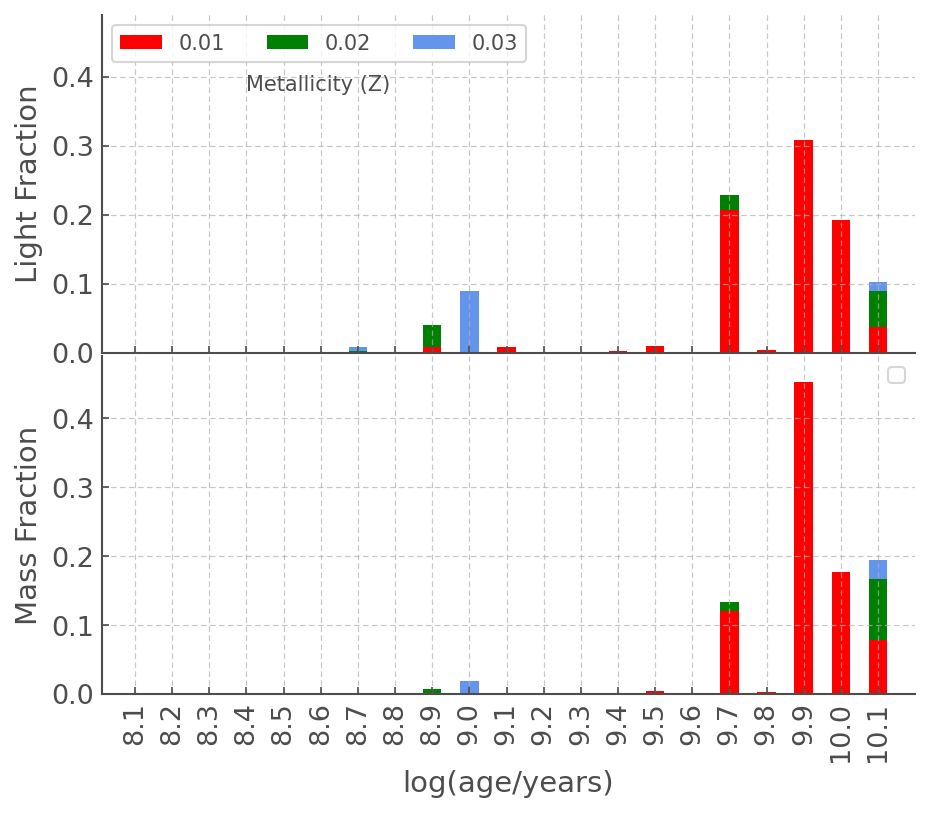

In [55]:
f, ax = plt.subplots(nrows=2, figsize=(7,6))
df_sfh.plot.bar(stacked=True, ax=ax[0], color={0.01: "red",
                                                0.02: "green",
                                                0.03: "cornflowerblue",
                                             })

df_sfh_mass.plot.bar(stacked=True, ax=ax[1], color={0.01: "red",
                                                0.02: "green",
                                                0.03: "cornflowerblue",
                                             })
plt.subplots_adjust(hspace=0.01)
for axis in ax:
    axis.set_xlim([15.1,37])
    axis.set_ylim([0,0.49])
    
ax[1].legend('')
ax[0].legend(ncol=3, loc=2)

ax[1].set_xlabel('log(age/years)')
ax[0].set_ylabel('Light Fraction')
ax[1].set_ylabel('Mass Fraction')
ax[0].text(19, 0.38, 'Metallicity (Z)')